In [145]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pickle
import os
import datetime as dt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')


In [146]:

def read_selected_stocks(_used_price='Close', 
                         _root_dir=root_dir,
                        _nan_selection_method = 0,
                        _number_of_dropped_stocks = 10,
                        _period_start = '1962-01-02',
                        _period_stop = '2022-12-09'):
    """
    inputs:
        _used_price = 'Close', which data of stocks should be used, opening, closing, adjusted closing
        _root_dir = root_dir, directory where pickle files are stored
        _nan_selection_method = 0, which is 
            0 if shocks with shortest timeseries data will be droped, 
            1 if simple average is used, w/o nan
        _number_of_dropped_stocks = 10, number of shortest stock will be dropped (only if _nan_selection=0)
        _period_start, first time period used 
        _period_stop, last time period used 

        
    output: dataframe contains time series with the average of selected stocks
    """
    # read timeseries date from pickle (df_raw)
    df_raw=pd.read_pickle(_root_dir +r'\50yr_timeSeries_data.pkl')
    
    # prepare & select the approprite value of stock (closing, opening, etc)
    df_close         = df_raw.loc[: ,(slice(None) ,[_used_price])].copy()
    df_close.columns = df_close.columns.droplevel(1)
    
    # read alternative portfolio data
    pickle_in = open( _root_dir +r'\alternate_port.pkl' ,'rb')
    alternate_port = pickle.load(pickle_in)
    
    i = 5
    df = df_close[alternate_port[f'cluster_{i}'].index.values.tolist()].copy()
    
    # create alternative porfolo by dropping nan stocks
    if _nan_selection_method == 0:
        # create temporaly data frame, will be used for selecting the columns from df_
        df_temp=pd.DataFrame(columns=['stock','ind','date','first_value'])

        for c in df.columns:
            i=0 # df.index
            while pd.isnull(df.loc[df.index[i],c]):
                i=i+1
            #print(c,i,df.index[i],df.loc[df.index[i],c])
            new_row={'stock':c,'ind':i, 'date':df.index[i],'first_value': df.loc[df.index[i],c]}
            df_temp.loc[len(df_temp)]=new_row

        # order in descending
        df_temp=df_temp.sort_values(by='ind', ascending=False)

        # lets drop 10 newest stocks (can be changed)
        for i in range(10):
            df=df.drop(df_temp.loc[df_temp.index[i],'stock'],axis=1)

        # we drop the history for which we don't have historical data
        df = df.dropna() 
        
        # Create Portfolio using stock weighting
        # Question: How to determine the weighting of each stock in the portfolio?
        dummy_weight = np.array([1/df.shape[1] for x in range(df.shape[1])])
        ticker_weight = dummy_weight # STILL NEED TO DO WEIGHTINGS
    
        # weigthed average of portfolio
        df_port = pd.Series(df.values.dot(ticker_weight) ,index=df.index)
    
    # create alternative porfolo by ignoring nan values from simple (!) average of stocks     
    elif _nan_selection_method == 1:
        df_port=df.mean(axis=1,skipna=True)
    else:
         # TODO - proper error handling
        df_port=df_close
        
    # slice the required set of the data    
    df_port=df_port.loc[_period_start : _period_stop]
    
    return df_port

In [147]:
root_dir= r'c:\Users\Zoli\Downloads\python\academy'

df=read_selected_stocks(_used_price='Close',
                        _root_dir = root_dir,
                        _nan_selection_method=0, 
                        _number_of_dropped_stocks = 10,
                        _period_start='2014-01-01', _period_stop='2021-12-31')
df.head()


Date
2014-01-02    87.011097
2014-01-03    87.107797
2014-01-06    86.849613
2014-01-07    87.543122
2014-01-08    87.650929
dtype: float64

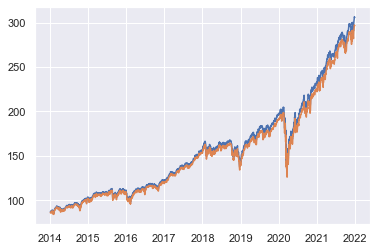

In [148]:
# comparision of two methods
df2=read_selected_stocks(_nan_selection_method=1, _period_start='2014-01-01', _period_stop='2021-12-31')
plt.plot(df)
plt.plot(df2);


In [149]:
def split_df_prediciton(_df=df):
    """
    spit the last one year from data frame (input: _df)
    we assumed that data is daily
    input: 
        _df = df, input data frame in time series format (index is time, one column with data)
    outputs:
        df_train, df_test: splited df

    """
    horizons = 52*5 # todo input + handle working days
    split_point = _df.shape[0] - horizons
    df_train, df_test = _df[:split_point],_df[split_point:] 

    return df_train, df_test

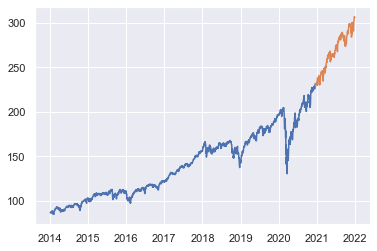

In [150]:
df_train, df_test = split_df_prediciton(df)
plt.plot(df_train)
plt.plot(df_test);


In [151]:
def ts_analysis(_df_train = df_train, _df_test = df_test, _resampling='1W', _debug=True):
    """
    classicial time series method used on dataframe, provides charts, prediction, and calculates RMSE
    inputs:
        _df_train = df_train, input data frame in time series format (index is time, one column with data)
        _df_test = df_test, input data frame, used for prediction validation

        _resampling = 'M', frequency of resampling, could be 1M, 1W, etc
        _debug=True , if true additional plots have been shown
           
    output: RMSE of the prediction
    """
    # params
    if _resampling == '1M':
        lags = 36 # 3 months
        steps = 12
    elif _resampling == '1W':
        lags = 156
        steps = 52
    else:
        # todo proper error handling, now default is used
        lags = 156
        steps = 52
    
    # resampling 
    df_train_resampled = _df_train.resample(_resampling).mean() 
    df_test_resampled = _df_test.resample(_resampling).mean()
    
    # overwrite steps
    steps = df_test_resampled.shape[0]
    
    # plot - if _debug is True
    if _debug == True:
        plt.figure(figsize=(16,8))
        plt.plot(df_train_resampled);

        tsa =seasonal_decompose(df_train_resampled)
        fig=tsa.plot()
        fig.set_size_inches((16, 8))
        fig.tight_layout()
        plt.show();
    
    # log transform + diffs
    df_train_resampled_log = np.log(df_train_resampled) 

    df_train_resampled_log_1 = df_train_resampled_log.diff().dropna()
    
    if _debug == True:
        pd.plotting.autocorrelation_plot(df_train_resampled_log_1);
        res=sm.tsa.stattools.adfuller(df_train_resampled_log_1)
        print ("First order diff transformation p-value:",res[1])


    df_train_resampled_log_2 = df_train_resampled_log_1.diff().dropna()
    if _debug == True:
        pd.plotting.autocorrelation_plot(df_train_resampled_log_2);
        res=sm.tsa.stattools.adfuller(df_train_resampled_log_2)
        print ("Second order diff transformation p-value:",res[1])
    
    # auto correlation functions of second order diff
    if _debug == True:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
        
        plot_acf(df_train_resampled_log_2,lags = lags,ax=ax1)  ## was 36 in case on 1M
        plot_pacf(df_train_resampled_log_2,lags = lags,ax=ax2) ## was 36 in case on 1M
        
        plt.show();
    
    # SARIMA fit default: (1,1,1)
    model_sm = sm.tsa.SARIMAX(df_train_resampled_log, order=(0,1,1), seasonal_order = (0,1,1,52))  ## 1M: seasonal_order = (0,1,1,12)
    model_sm_fitted = model_sm.fit()
    print(model_sm_fitted.summary())

    # Forecasting with a confidence interval    
    prediction_log = model_sm_fitted.get_forecast(steps = steps).summary_frame()  
    prediction = np.exp(prediction_log)

    fig, ax = plt.subplots(figsize = (15,5))

    plt.plot(df_train_resampled, label = "train")
    plt.plot(df_test_resampled, label = "test")
    #plt.ylim(0,300) # v006

    prediction['mean'].plot(ax = ax, style = 'k--', label = "prediction") # Plotting the mean

    ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1); 
    plt.axvline(x= df_test.index[0], color='orange'); 
    plt.legend()
    
    # calculate RMSE
    rmse =  np.sqrt(mean_squared_error(df_test_resampled, prediction['mean']))
    
    return rmse


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  364
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                 756.131
Date:                            Thu, 20 Apr 2023   AIC                          -1506.262
Time:                                    14:23:53   BIC                          -1495.042
Sample:                                01-05-2014   HQIC                         -1501.777
                                     - 12-20-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2905      0.022     13.131      0.000       0.247       0.334
ma.S.L52      -0.6676      0.096   

24.061422015360282

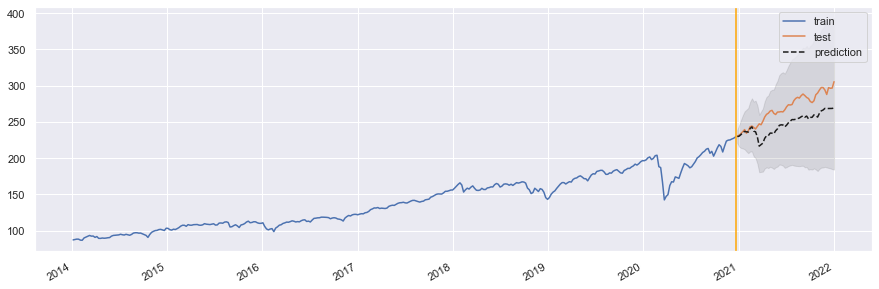

In [152]:
ts_analysis(df_train, df_test, _resampling = '1W', _debug = False)

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                  42.046
Date:                            Thu, 20 Apr 2023   AIC                            -78.092
Time:                                    14:23:55   BIC                            -73.790
Sample:                                01-31-2014   HQIC                           -76.690
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1323      0.181      0.731      0.465      -0.223       0.487
ma.S.L52    2.215e-05   1.51e-10   

17.26544830159205

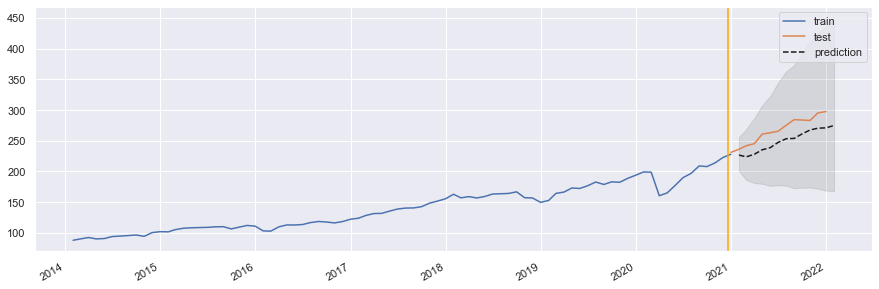

In [153]:
ts_analysis(df_train, df_test, _resampling = '1M', _debug = False)

In [13]:
#################################
# NOTHING HAS BEEN DONE TO ANY CODE FURTHER BELOW
#################################

In [68]:
###################### linear regression 

In [195]:
# try monthly again
df_ts_monthly=df_ts.resample('1M').mean() ## was 1M -- no removal of last 1 year, only later ---
df_ts_monthly.head()

Date
2012-05-31    58.855323
2012-06-30    58.646332
2012-07-31    59.506354
2012-08-31    60.189592
2012-09-30    62.227578
Freq: M, dtype: float64

In [225]:
from sklearn.linear_model import LinearRegression

# convert from time series to PD
df_ts_monthly_lin=pd.DataFrame(df_ts_monthly,index=df_ts_monthly.index)
df_ts_monthly_lin['Time'] = np.arange(len(df_ts_monthly_lin.index))
df_ts_monthly_lin.columns=['Stock','Time']
df_ts_monthly_lin.head()


,Stock,Time
Date,,
2012-05-31,58.855323,0
2012-06-30,58.646332,1
2012-07-31,59.506354,2
2012-08-31,60.189592,3
2012-09-30,62.227578,4


In [226]:
df_ts_monthly_lin['Month'] = df_ts_monthly_lin.index.month
df_ts_monthly_lin['Year'] = df_ts_monthly_lin.index.month
for i in range(12,18,1):
    df_ts_monthly_lin['Lag_'+str(i)] = df_ts_monthly_lin.Stock.shift(i)

df_ts_monthly_lin['Lag_24'] = df_ts_monthly_lin.Stock.shift(24)

df_ts_monthly_lin.head(36).tail(12)

,Stock,Time,Month,Year,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_24
Date,,,,,,,,,,,
2014-05-31,90.376752,24,5,5,74.922957,71.346876,70.436002,68.551975,66.454264,63.220390,58.855323
2014-06-30,93.630713,25,6,6,73.966207,74.922957,71.346876,70.436002,68.551975,66.454264,58.646332
2014-07-31,94.397970,26,7,7,76.822403,73.966207,74.922957,71.346876,70.436002,68.551975,59.506354
2014-08-31,95.250599,27,8,8,77.390749,76.822403,73.966207,74.922957,71.346876,70.436002,60.189592
2014-09-30,96.171061,28,9,9,79.186333,77.390749,76.822403,73.966207,74.922957,71.346876,62.227578
2014-10-31,93.958556,29,10,10,81.690377,79.186333,77.390749,76.822403,73.966207,74.922957,62.268235
2014-11-30,100.020543,30,11,11,84.758114,81.690377,79.186333,77.390749,76.822403,73.966207,62.059870
2014-12-31,101.569178,31,12,12,86.128116,84.758114,81.690377,79.186333,77.390749,76.822403,63.220390
2015-01-31,101.277318,32,1,1,87.567399,86.128116,84.758114,81.690377,79.186333,77.390749,66.454264


In [227]:
horizons = 12 # TODO needs to be aligned with above
split_point = df_ts_monthly_lin.shape[0] - horizons
train, test = df_ts_monthly_lin[24:split_point],df_ts_monthly_lin[split_point:] # 24 depends on LAGs used

In [228]:
X_train = train[df_ts_monthly_lin.columns[2:]] ## TODO: 2 is used because Time column is there, otherwise 1
y_train = train['Stock']
X_test = test[df_ts_monthly_lin.columns[2:]] ## TODO: 2 is used because Time column is there, otherwise 1
y_test = test['Stock']


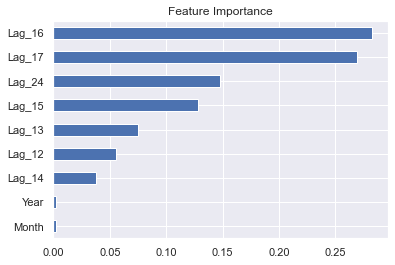

In [229]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', title='Feature Importance');

MSE = 1144.81


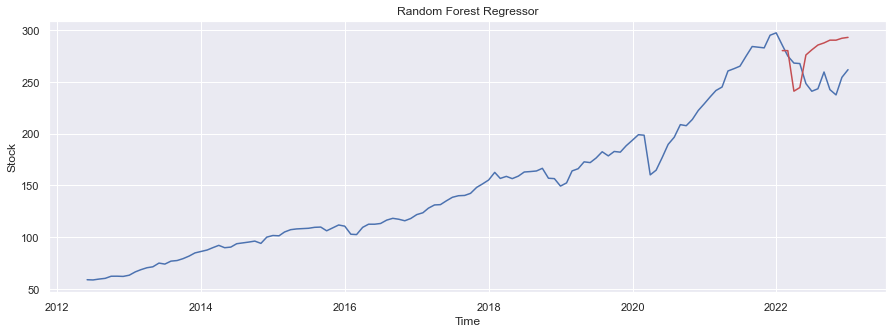

In [230]:
from sklearn.metrics import mean_squared_error

perf_summary=dict()

MSE = mean_squared_error(y_test, y_pred)
print("MSE = %.2f"%MSE)
perf_summary['RF 1 model lag 12'] = MSE

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(df_ts_monthly_lin.index, df_ts_monthly_lin.Stock, c='b', label='Historical data')
plt.plot(X_test.index, y_pred, c='r', label='Random Forest Regressor')

plt.xlabel('Time')
plt.ylabel('Stock')
plt.title('Random Forest Regressor')
plt.show()

In [231]:
forecast = np.mean(train['Stock'][-24:]) # 24or 36 depending on LAG
y_pred_mean = np.ones(12,)*forecast
y_pred_mean

array([233.11992579, 233.11992579, 233.11992579, 233.11992579,
       233.11992579, 233.11992579, 233.11992579, 233.11992579,
       233.11992579, 233.11992579, 233.11992579, 233.11992579])

MSE benchmark naive= 781.07
MSE RF= 1144.81


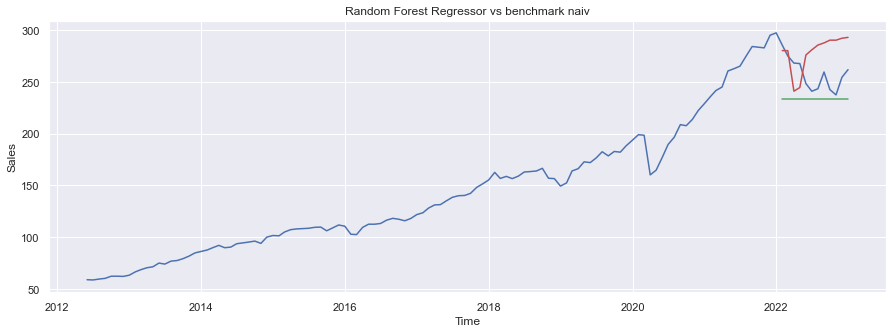

In [232]:
MSE = mean_squared_error(y_test, y_pred_mean)
print("MSE benchmark naive= %.2f"%MSE)
perf_summary['Naive mean 36 months'] = MSE

MSE = mean_squared_error(y_test, y_pred)
print("MSE RF= %.2f"%MSE)

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(df_ts_monthly_lin.index, df_ts_monthly_lin.Stock, c='b', label='Historical data')
plt.plot(X_test.index, y_pred, c='r', label='Random Forest Regressor')
plt.plot(X_test.index, y_pred_mean, c='g', label='Benchmark based on 36 month')

plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Random Forest Regressor vs benchmark naiv')
plt.show()

In [233]:
y_pred_seas = train['Stock'][-12:]
y_pred_seas

Date
2021-01-31    235.798751
2021-02-28    241.639661
2021-03-31    244.992507
2021-04-30    260.508962
2021-05-31    262.746312
2021-06-30    265.153959
2021-07-31    274.817517
2021-08-31    284.131799
2021-09-30    283.497211
2021-10-31    282.819982
2021-11-30    295.033238
2021-12-31    297.319979
Freq: M, Name: Stock, dtype: float64

MSE benchmark seasonal naive= 1101.12
MSE RF= 1144.81


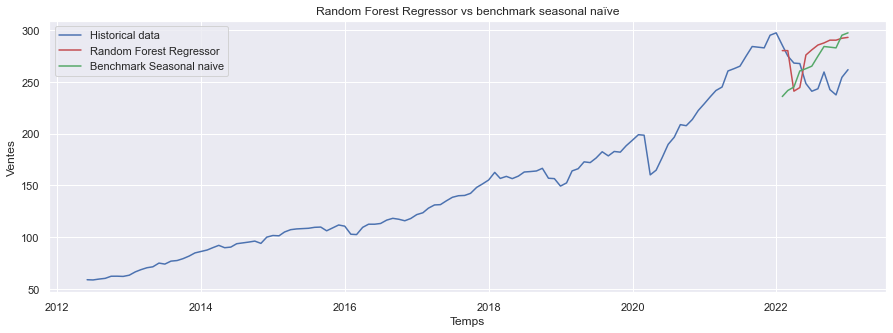

In [234]:
MSE = mean_squared_error(y_test, y_pred_seas)
print("MSE benchmark seasonal naive= %.2f"%MSE)
perf_summary['Seasonal naive'] = MSE

MSE = mean_squared_error(y_test, y_pred)
print("MSE RF= %.2f"%MSE)

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(df_ts_monthly_lin.index, df_ts_monthly_lin.Stock, c='b', label='Historical data')
plt.plot(X_test.index, y_pred, c='r', label='Random Forest Regressor')
plt.plot(X_test.index, y_pred_seas, c='g', label='Benchmark Seasonal naive')

plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('Random Forest Regressor vs benchmark seasonal naïve')
plt.legend()
plt.show()

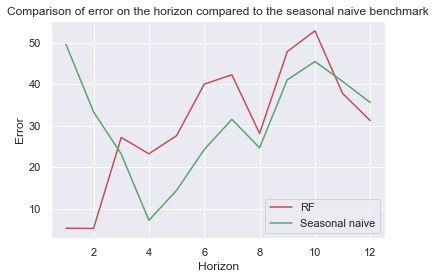

In [235]:
plt.plot(np.arange(1,13,1), np.abs(df_ts_monthly_lin.Stock[-12:].values-y_pred[-12:]), c='r', label='RF')
plt.plot(np.arange(1,13,1), np.abs(df_ts_monthly_lin.Stock[-12:].values-y_pred_seas), c='g', label='Seasonal naive')

plt.xlabel('Horizon')
plt.ylabel('Error')
plt.title("Comparison of error on the horizon compared to the seasonal naive benchmark")
plt.legend()
plt.show()

In [236]:
# direct approach
for i in range(1,12,1):
    df_ts_monthly_lin['Lag_'+str(i)] = df_ts_monthly_lin.Stock.shift(i)


In [237]:
horizons = 12
cutoff_index = df_ts_monthly_lin.shape[0]-horizons

predictions = []
pred_index = []
y_true = []
for h in np.arange(1,horizons+1,1):

  train, test = df_ts_monthly_lin[24:cutoff_index], df_ts_monthly_lin[cutoff_index:cutoff_index+h]
  if h != 1:
    print("Horizon: ", h)
    print("Columns: ", df_ts_monthly_lin.columns[1:-h+1])
    print("")
    X_train = train[df_ts_monthly_lin.columns[1:-h+1]]
    X_test = test[df_ts_monthly_lin.columns[1:-h+1]]
  else : 
    print("Horizon: ", h)
    print("Columns: ", df_ts_monthly_lin.columns[1:])
    X_train = train[df_ts_monthly_lin.columns[1:]]
    X_test = test[df_ts_monthly_lin.columns[1:]]

  y_train = train['Stock']
  y_test = test['Stock']

  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  predictions.append(y_pred[h-1])
  pred_index.append(X_test.index[h-1])
  y_true.append(y_test[h-1])

MSE = mean_squared_error(y_true, predictions)
print("MSE = %.2f"%MSE)
perf_summary['RF Direct Approach - 12 models'] = MSE


Horizon:  1
Columns:  Index(['Time', 'Month', 'Year', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_15',
       'Lag_16', 'Lag_17', 'Lag_24', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4',
       'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11'],
      dtype='object')
Horizon:  2
Columns:  Index(['Time', 'Month', 'Year', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_15',
       'Lag_16', 'Lag_17', 'Lag_24', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4',
       'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10'],
      dtype='object')

Horizon:  3
Columns:  Index(['Time', 'Month', 'Year', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_15',
       'Lag_16', 'Lag_17', 'Lag_24', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4',
       'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9'],
      dtype='object')

Horizon:  4
Columns:  Index(['Time', 'Month', 'Year', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_15',
       'Lag_16', 'Lag_17', 'Lag_24', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4',
       'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8'],
      dtype='object')

Horizon:

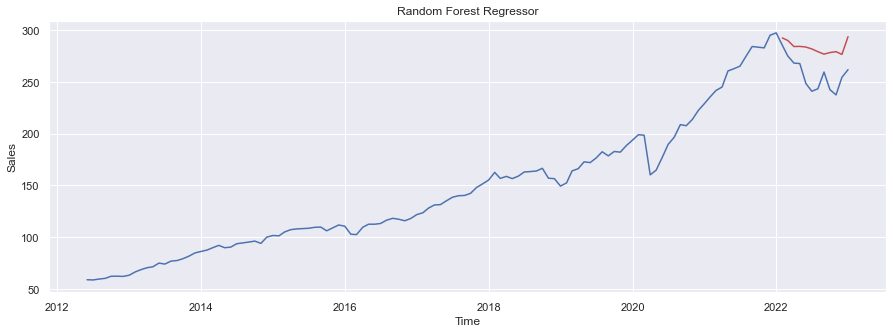

In [238]:
fig, ax = plt.subplots(figsize = (15,5))

plt.plot(df_ts_monthly_lin.index, df_ts_monthly_lin.Stock, c='b', label='Historical data')
plt.plot(pred_index, predictions, c='r', label='Random Forest Regressor')

plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Random Forest Regressor')
plt.show()

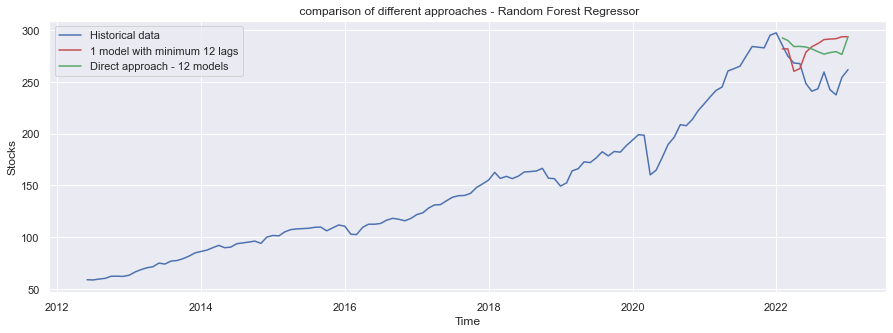

In [239]:
fig, ax = plt.subplots(figsize = (15,5))

plt.plot(df_ts_monthly_lin.index, df_ts_monthly_lin.Stock, c='b', label='Historical data')
plt.plot(X_test.index, y_pred, c='r', label='1 model with minimum 12 lags')
plt.plot(pred_index, predictions, c='g', label='Direct approach - 12 models')

plt.xlabel('Time')
plt.ylabel('Stocks')
plt.title(' comparison of different approaches - Random Forest Regressor')
plt.legend()
plt.show()

In [240]:
## from here -- old version, cleaned

In [241]:

X=df_ts_monthly_lin.loc[:, ['Time']] 
y=df_ts_monthly_lin.loc[:, ['Stock']] 

In [242]:
model_lin = LinearRegression()
model_lin.fit(X, y)



LinearRegression()

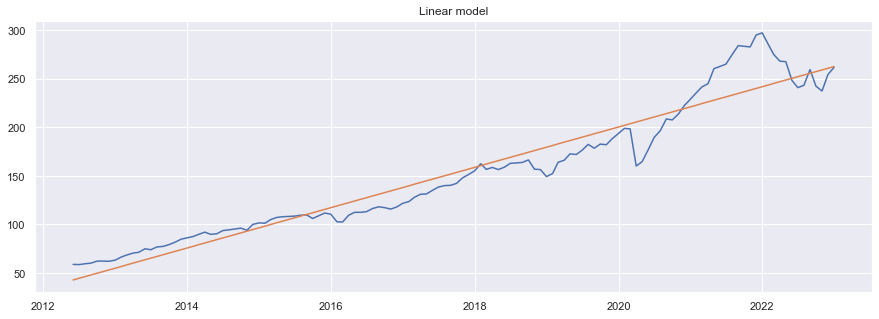

In [243]:
y_pred = pd.DataFrame(model_lin.predict(X), index=X.index, columns=['BLK linear fit'])

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(y)
plt.plot(y_pred)

ax.set_title('Linear model');

In [244]:
# not needed anymore, lags has already been created earlier

###df_ts_monthly_lin['Lag_1'] = df_ts_monthly_lin['BLK'].shift(1)
##df_ts_monthly_lin['Lag_1'] = df_ts_monthly_lin[[0]].shift(1)
##df_ts_monthly_lin.head()

In [246]:
X = df_ts_monthly_lin.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
##y = df_ts_monthly_lin.loc[:, 'BLK']  # create the target
y = df_ts_monthly_lin.loc[:, 'Stock']  # create the target

y, X = y.align(X, join='inner')  # drop corresponding values in target

model_lin = LinearRegression()
model_lin.fit(X, y)

##y_pred = pd.DataFrame(model_lin.predict(X), index=X.index, columns=['BLK lag'] )
y_pred = pd.DataFrame(model_lin.predict(X), index=X.index, columns=['lag'] )

y_pred

,lag
Date,
2012-06-30,60.635243
2012-07-31,60.426661
2012-08-31,61.284997
2012-09-30,61.966897
2012-10-31,64.000890
...,...
2022-08-31,244.736672
2022-09-30,260.893146
2022-10-31,243.889232


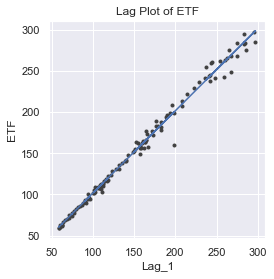

In [247]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
##ax.plot(X['Lag_1'], y_pred['BLK lag'])
ax.plot(X['Lag_1'], y_pred['lag'])


ax.set_aspect('equal')
##ax.set_ylabel('BLK')
ax.set_ylabel('ETF')
ax.set_xlabel('Lag_1')
##ax.set_title('Lag Plot of BLK');
ax.set_title('Lag Plot of ETF');

In [78]:
df_ts_monthly_lin_save.tail()

,0,Time,Lag_1
Date,,,
2022-11-13,251.643406,547,245.318221
2022-11-20,256.743609,548,251.643406
2022-11-27,259.717726,549,256.743609
2022-12-04,263.203578,550,259.717726
2022-12-11,259.918663,551,263.203578


In [ ]:
############### Prophet

In [248]:
import prophet as pt

In [249]:
df_ts_monthly_lin.head()

,Stock,Time,Month,Year,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,...,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-31,58.855323,0,5,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-30,58.646332,1,6,6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-31,59.506354,2,7,7,NaN,NaN,NaN,NaN,NaN,NaN,...,58.855323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-08-31,60.189592,3,8,8,NaN,NaN,NaN,NaN,NaN,NaN,...,58.646332,58.855323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-09-30,62.227578,4,9,9,NaN,NaN,NaN,NaN,NaN,NaN,...,59.506354,58.646332,58.855323,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [255]:
##df_ts_monthly_pt=df_ts_monthly_lin.rename(columns={'BLK': 'y'})
df_ts_monthly_pt=df_ts_monthly_lin.rename(columns={'Stock': 'y'})

df_ts_monthly_pt=df_ts_monthly_pt.drop(df_ts_monthly_pt.columns[1:],axis=1)
df_ts_monthly_pt['ds']=df_ts_monthly_pt.index

df_ts_monthly_pt.head()

,y,ds
Date,,
2012-05-31,58.855323,2012-05-31
2012-06-30,58.646332,2012-06-30
2012-07-31,59.506354,2012-07-31
2012-08-31,60.189592,2012-08-31
2012-09-30,62.227578,2012-09-30


In [263]:
horizons = 12 # TODO needs to be aligned with above

split_point = df_ts_monthly_pt.shape[0] - horizons
train, test = df_ts_monthly_pt[24:split_point],df_ts_monthly_pt[split_point:] # 24 depends on LAGs used

train.tail()

,y,ds
Date,,
2021-08-31,284.131799,2021-08-31
2021-09-30,283.497211,2021-09-30
2021-10-31,282.819982,2021-10-31
2021-11-30,295.033238,2021-11-30
2021-12-31,297.319979,2021-12-31


In [264]:
model_pt = pt.Prophet(interval_width=0.95)
model_pt.fit(train)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [266]:
future_dates = model_pt.make_future_dataframe(periods=horizons, freq='MS') 
future_dates.tail()

,ds
99,2022-08-01
100,2022-09-01
101,2022-10-01
102,2022-11-01
103,2022-12-01


In [267]:
forecast = model_pt.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2014-05-31,91.481300,78.695129,103.835591
1,2014-06-30,93.825068,80.795287,105.160776
2,2014-07-31,96.275237,84.575147,108.966146
3,2014-08-31,96.598246,84.641943,109.037335
4,2014-09-30,96.578763,84.285457,109.425072


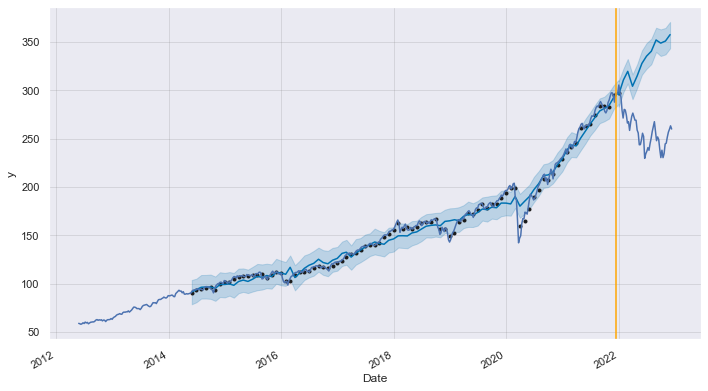

In [269]:
model_pt.plot(forecast, uncertainty=True)

ax = y_save.plot()
plt.axvline(x= dt.date(2021,12,15), color='orange'); 

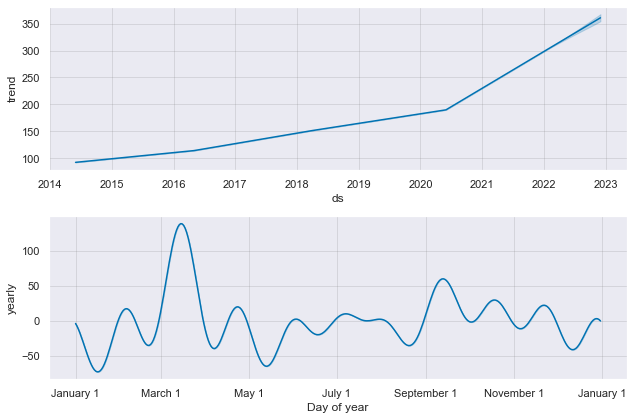

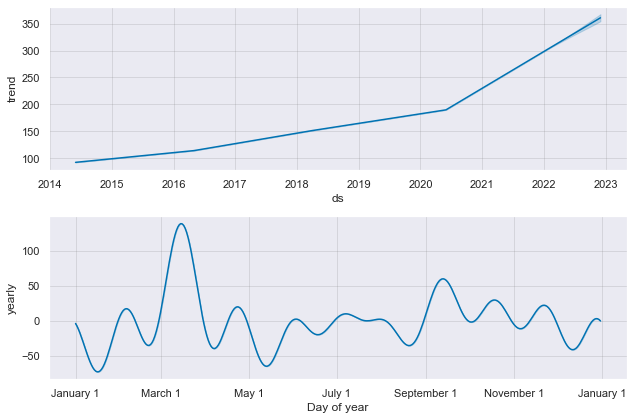

In [270]:
model_pt.plot_components(forecast)


In [284]:
rmse_pt =  np.sqrt(mean_squared_error(test['y'], forecast.trend.tail(horizons)))
print("RMSE of Prophet prediction is:", rmse_pt)


RMSE of Prophet prediction is: 78.82942296437412
